# Hurricane Data to SQL database


load necessary packages

In [1]:
import sqlite3
import pandas as pd
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.append('..')
# from functions import *

load necessary dataset

## Hurricane Risk Score Index

In [3]:
#Load the shapefile
shapefile_path = "../../shapefile/NRI_Shapefile_Counties/NRI_Shapefile_Counties.shp"
print('loading')
gdf = gpd.read_file(shapefile_path)
print('loaded')
#Filter the data to exclude Alaska and the islands
mainland_usa_gdf = gdf[
    (gdf['STATE'] != 'Alaska') & 
    (gdf['STATE'] != 'Hawaii') & 
    (gdf['STATE'] != 'Puerto Rico') & 
    (gdf['STATE'] != 'Guam') & 
    (gdf['STATE'] != 'American Samoa') & 
    (gdf['STATE'] != 'Northern Mariana Islands') & 
    (gdf['STATE'] != 'Virgin Islands')
].copy()

#mainland_usa_gdf.loc[:, 'HRCN_RISKS'].replace(-9999, np.nan, inplace=True)
mainland_usa_gdf = mainland_usa_gdf[mainland_usa_gdf['HRCN_RISKS'] != -9999]
#Takes around 5 mins to run

loading
loaded


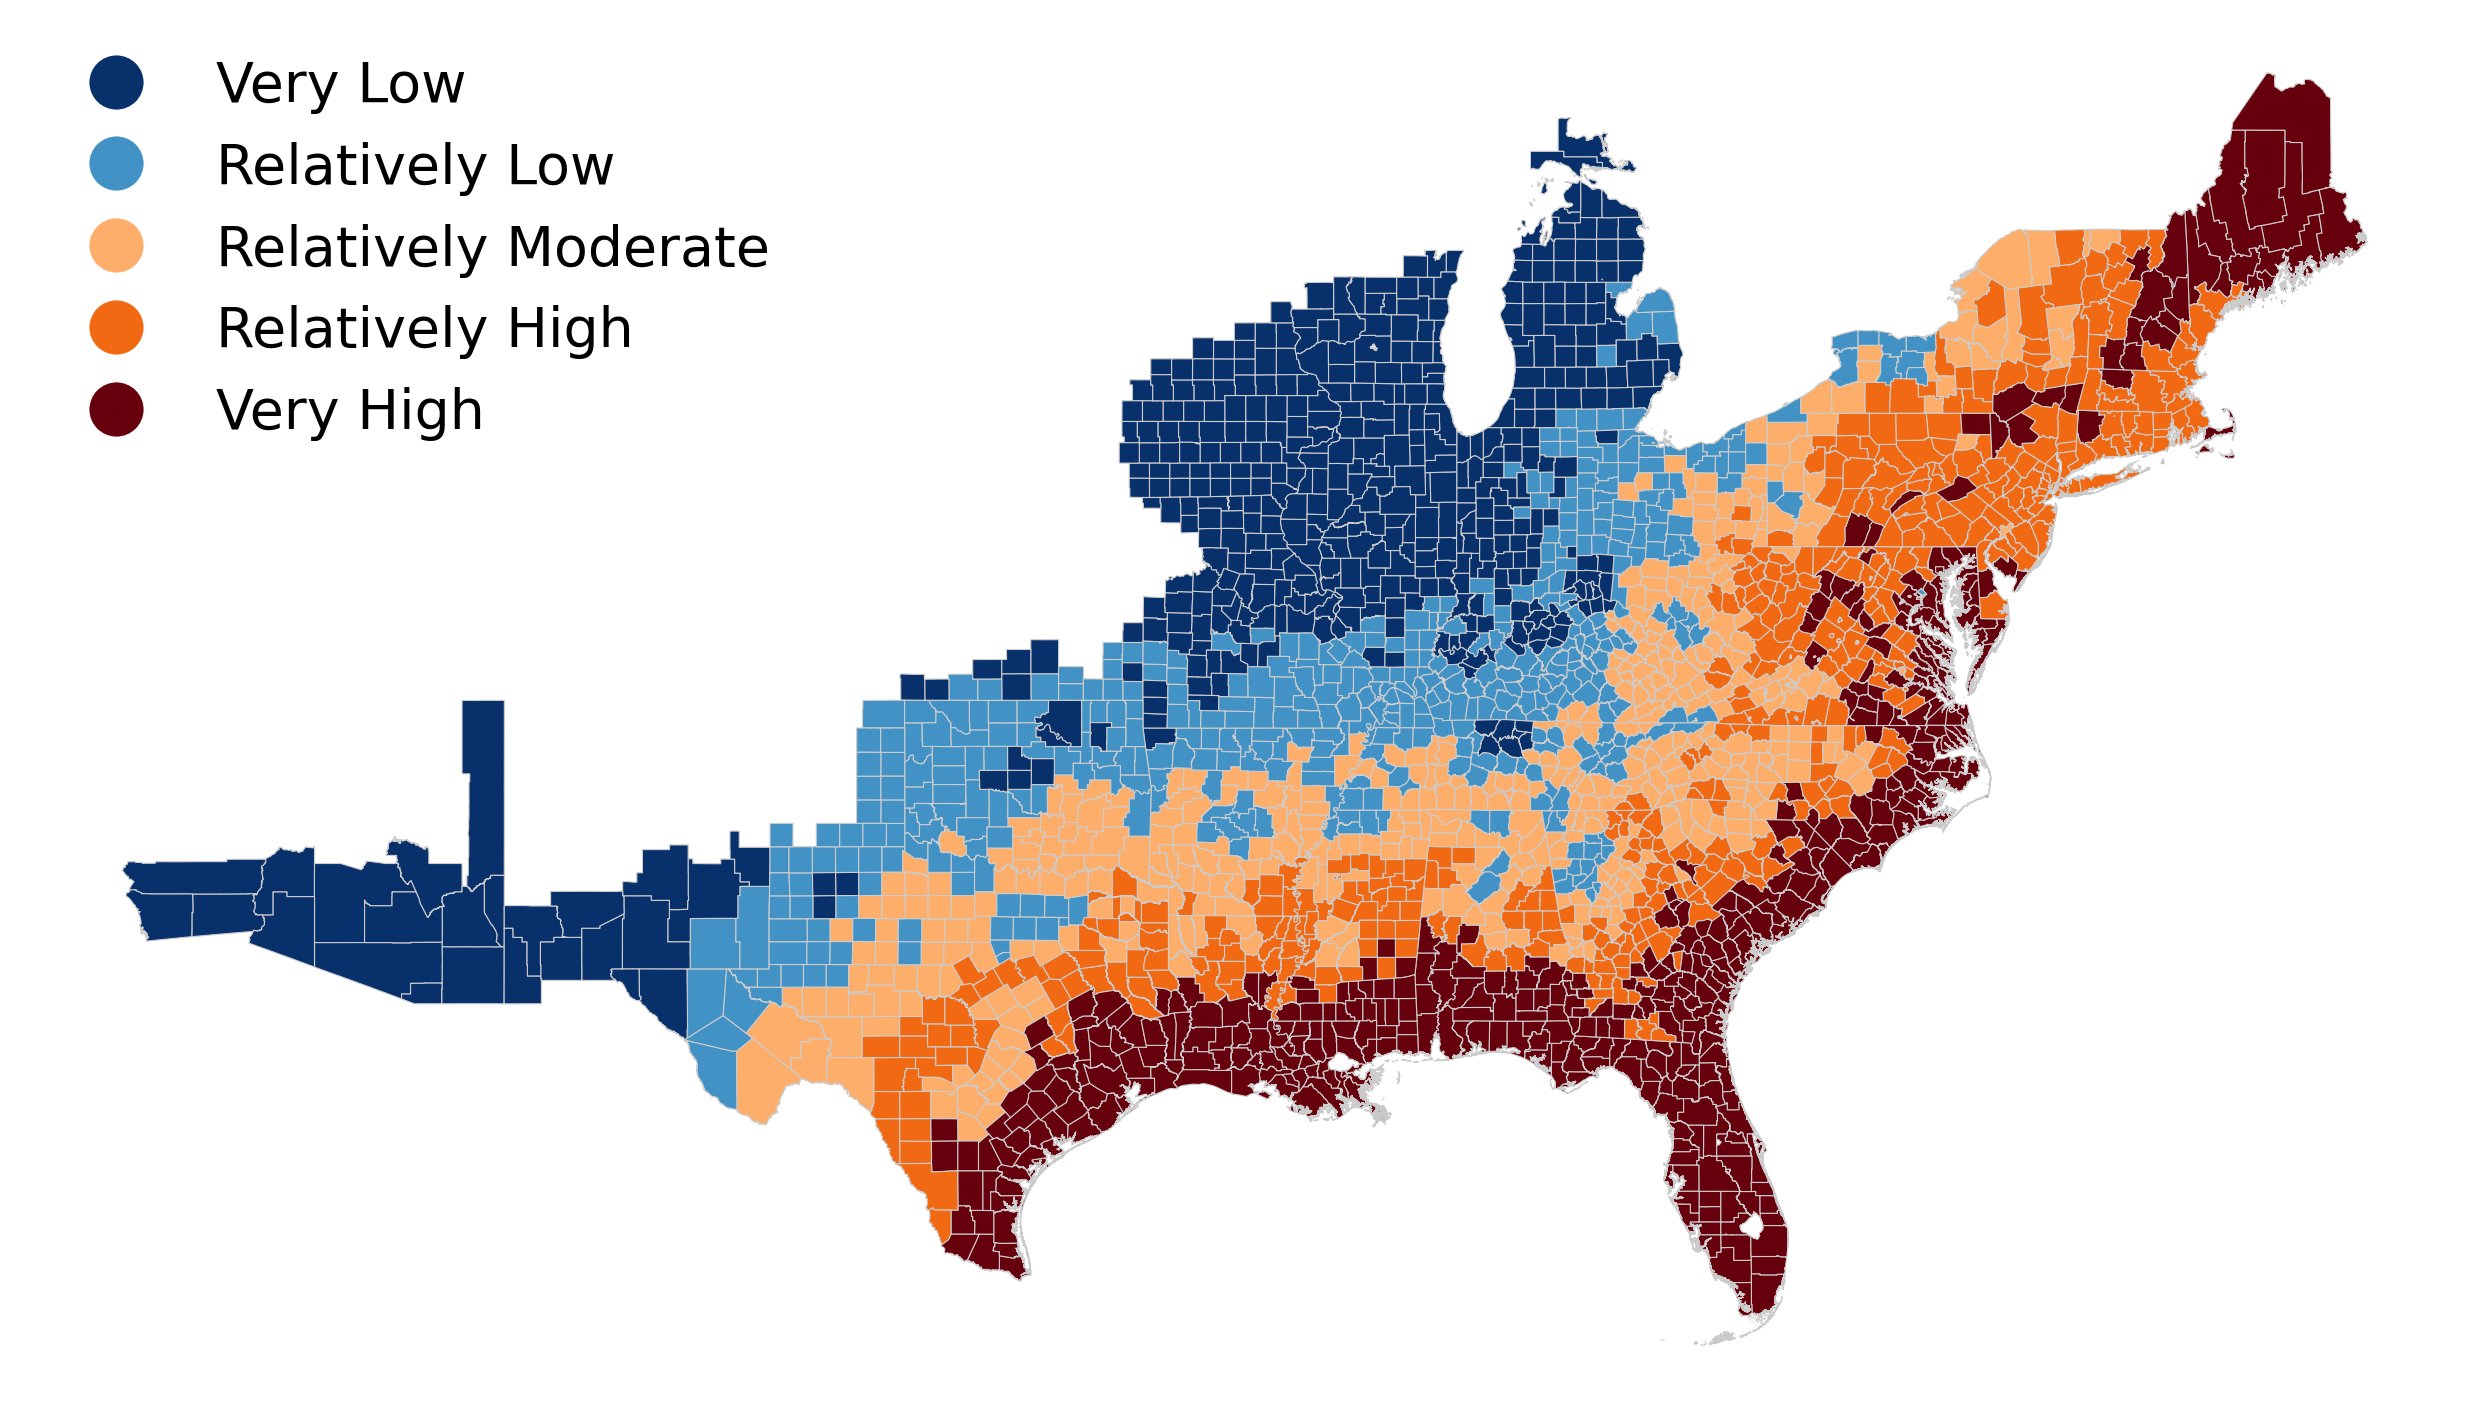

In [11]:
#5 bins based on quantiles to categorize the scores into 5 distinct sections
mainland_usa_gdf['HRCN_HLRB_NORM'] = (mainland_usa_gdf['HRCN_HLRB'] - mainland_usa_gdf['HRCN_HLRB'].mean())/ mainland_usa_gdf['HRCN_HLRB'].std()
mainland_usa_gdf['HRCN_RISK_CATEGORY_QUANTILE'] = pd.qcut(mainland_usa_gdf['HRCN_HLRB_NORM'], q=5, labels=['Very Low', "Relatively Low", 'Relatively Moderate', 'Relatively High', 'Very High'])
colors = ['#08306b', '#4292c6', '#fdae6b', '#f16913', '#67000d']
custom_cmap = ListedColormap(colors) # type: ignore
#Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(25, 15))
plt.grid(False)
mainland_usa_gdf.plot(column='HRCN_RISK_CATEGORY_QUANTILE', cmap=custom_cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'loc': 'upper left', 'fontsize': 40, 'frameon': False})
# ax.set_title('Hurricane Risk Heatmap (USA) on county level', fontdict={'fontsize': '25', 'fontweight' : '3'})
# Create custom legend
legend_labels = ['Very Low', 'Relatively Low', 'Relatively Moderate', 'Relatively High', 'Very High']
legend_colors = colors  # Assuming 'colors' is defined as in your code snippet
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=40) for label, color in zip(legend_labels, legend_colors)]
ax.legend(handles=legend_handles, loc='upper left', fontsize=40, frameon=False)
#Remove all axis values
ax.set_xticks([])
ax.set_yticks([])
#Remove all axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Display the map
#Save plot heatmap
plt.tight_layout()
plt.savefig('../../Plots/Norm_ALRA.png')
plt.show()

## Subset data to HRCN to MSA

In [18]:
mainland_usa_gdf_msa = mainland_usa_gdf.copy()
#load cbsa_to_fips xlsx file
cbsa_to_fips_df = pd.read_excel('../../Data/cbsa_to_fips.xlsx', dtype={'MSA': str, 'STCOFIPS': str, 'statename': str})
cbsa_to_fips_df = cbsa_to_fips_df[['MSA', 'STCOFIPS', 'statename']]
#create new column in mainland_usa_gdf called MSA looking up in cbsa_to_fips_df
mainland_usa_gdf_msa.loc[:, 'MSA'] = mainland_usa_gdf_msa['STCOFIPS'].map(cbsa_to_fips_df.set_index('STCOFIPS')['MSA'])
#extract stcofips where msa is na
stcofips_na = mainland_usa_gdf_msa[mainland_usa_gdf_msa['MSA'].isna()]['STCOFIPS']
#remove na
mainland_usa_gdf_msa = mainland_usa_gdf_msa[~mainland_usa_gdf_msa['MSA'].isna()]
display(mainland_usa_gdf_msa)


,NRI_ID,STATE,STATEABBRV,STATEFIPS,COUNTY,COUNTYTYPE,COUNTYFIPS,STCOFIPS,POPULATION,BUILDVALUE,...,WNTW_RISKV,WNTW_RISKS,WNTW_RISKR,NRI_VER,Shape_Leng,Shape_Area,geometry,HRCN_ALRA_Norm,HRCN_RISK_CATEGORY_QUANTILE,MSA
0,C01001,Alabama,AL,01,Autauga,County,001,01001,58764,9.123274e+09,...,8494.906508,12.217626,Very Low,March 2023,249970.262434,2.208589e+09,"POLYGON ((-9619432.840 3847073.744, -9619428.2...",0.000460,Relatively High,33860
1,C01003,Alabama,AL,01,Baldwin,County,003,01003,231365,4.596848e+10,...,65619.701638,52.083996,Relatively Low,March 2023,923868.312116,5.730947e+09,"MULTIPOLYGON (((-9787951.364 3588674.829, -978...",2.672926,Very High,19300
2,C01005,Alabama,AL,01,Barbour,County,005,01005,25160,4.847697e+09,...,15501.730336,19.535476,Very Low,March 2023,320882.938340,3.257909e+09,"POLYGON ((-9491049.106 3781487.459, -9490968.1...",0.477404,Very High,21640
3,C01007,Alabama,AL,01,Bibb,County,007,01007,22239,3.146947e+09,...,7496.186940,11.104041,Very Low,March 2023,227920.125168,2.311979e+09,"POLYGON ((-9687669.284 3924165.445, -9687659.8...",-0.394053,Relatively High,13820
4,C01009,Alabama,AL,01,Blount,County,009,01009,58992,7.815620e+09,...,17175.160729,21.444480,Very Low,March 2023,292630.369977,2.456906e+09,"POLYGON ((-9622917.941 4063649.874, -9622939.5...",-0.481260,Relatively Moderate,13820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3110,C55123,Wisconsin,WI,55,Vernon,County,123,55123,30574,7.252761e+09,...,39811.340948,40.311804,Relatively Low,March 2023,305592.639612,4.032468e+09,"POLYGON ((-10053513.068 5422980.224, -10053519...",-0.536460,Very Low,29100
3112,C55127,Wisconsin,WI,55,Walworth,County,127,55127,106413,2.939267e+10,...,38064.902537,39.039135,Relatively Low,March 2023,210751.234828,2.763760e+09,"POLYGON ((-9830236.517 5287472.816, -9830237.7...",-0.534688,Very Low,48580
3114,C55131,Wisconsin,WI,55,Washington,County,131,55131,136723,3.478729e+10,...,134361.664563,70.760420,Relatively Moderate,March 2023,191060.920811,2.136044e+09,"POLYGON ((-9800623.528 5393847.204, -9800620.9...",-0.536482,Very Low,33340
3115,C55133,Wisconsin,WI,55,Waukesha,County,133,55133,406817,9.768647e+10,...,374901.188849,88.768692,Relatively High,March 2023,212117.319660,2.814109e+09,"POLYGON ((-9803174.519 5340942.920, -9803186.6...",-0.536642,Very Low,33340


In [43]:
#show columns that have HRCN in mainland_usa_gdf
# display(mainland_usa_gdf.columns[mainland_usa_gdf.columns.str.contains('HRCN')])
#Save mainland_usa_gdf_HRCN file which includes HRCN columns
hrcn_columns = [col for col in mainland_usa_gdf_msa.columns if 'HRCN' in col]
selected_columns = ['MSA','geometry', 'STATE'] + hrcn_columns
mainland_usa_gdf_msa = mainland_usa_gdf_msa[selected_columns]
display(mainland_usa_gdf_msa)
#Save Pickle file
mainland_usa_gdf_msa.to_pickle('../../Data/mainland_usa_gdf_msa.pkl')
mainland_usa_gdf_msa.columns

,MSA,geometry,STATE,HRCN_EVNTS,HRCN_AFREQ,HRCN_EXP_A,HRCN_EXPB,HRCN_EXPP,HRCN_EXPPE,HRCN_EXPA,...,HRCN_EALPE,HRCN_EALA,HRCN_EALT,HRCN_EALS,HRCN_ALRB,HRCN_ALRP,HRCN_ALRA,HRCN_ALR_N,HRCN_RISKV,HRCN_RISKS
0,33860,"POLYGON ((-9619432.840 3847073.744, -9619428.2...",Alabama,13.0,0.080450,610.470508,9.121108e+09,58748.668261,6.814846e+11,2.449691e+07,...,2.281881e+04,4.678990e+04,9.153931e+05,66.364029,9.270623e-05,3.347524e-08,0.001901,64.677907,1.014608e+06,67.653656
1,19300,"MULTIPOLYGON (((-9787951.364 3588674.829, -978...",Alabama,50.0,0.248233,1674.843955,4.596806e+10,231362.821627,2.683809e+12,1.380755e+08,...,6.327440e+06,1.566622e+06,1.815766e+08,99.005620,3.778297e-03,2.357612e-06,0.011345,94.682231,1.895320e+08,98.878421
2,21640,"POLYGON ((-9491049.106 3781487.459, -9490968.1...",Alabama,21.0,0.116398,913.646511,4.847697e+09,25160.000000,2.918560e+11,1.210758e+08,...,2.097548e+04,4.342251e+05,1.980247e+06,72.805880,3.145919e-04,7.186926e-08,0.003586,78.815391,3.079796e+06,77.164648
3,13820,"POLYGON ((-9687669.284 3924165.445, -9687659.8...",Alabama,11.0,0.066724,632.486798,3.146947e+09,22239.000000,2.579724e+11,4.819356e+06,...,3.500564e+03,2.442449e+03,1.834546e+05,49.070471,5.640757e-05,1.356953e-08,0.000507,59.446606,2.226110e+05,51.099148
4,13820,"POLYGON ((-9622917.941 4063649.874, -9622939.5...",Alabama,6.0,0.039238,657.196555,7.815387e+09,58989.060165,6.842731e+11,2.776569e+08,...,3.335969e+03,5.533117e+04,2.479183e+05,52.399481,2.421447e-05,4.874959e-09,0.000199,49.632512,3.010121e+05,54.015253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3110,29100,"POLYGON ((-10053513.068 5422980.224, -10053519...",Wisconsin,1.0,0.007114,824.625839,7.248688e+09,30561.000559,3.545076e+11,2.057475e+08,...,6.368846e+00,7.409740e+02,4.256973e+03,4.626027,4.839027e-07,1.795769e-11,0.000004,2.204929,4.974228e+03,5.069538
3112,48580,"POLYGON ((-9830236.517 5287472.816, -9830237.7...",Wisconsin,1.0,0.005844,582.417186,2.939239e+10,106412.801613,1.234388e+12,1.898404e+08,...,4.992092e+01,1.884799e+03,2.011794e+04,19.584955,6.186311e-07,4.044175e-11,0.000010,4.366623,2.029927e+04,17.900404
3114,33340,"POLYGON ((-9800623.528 5393847.204, -9800620.9...",Wisconsin,0.0,0.009284,440.061012,3.478729e+10,136723.000000,1.585987e+12,1.806074e+08,...,4.701114e+01,6.280835e+02,1.733585e+04,17.769131,4.789324e-07,2.964157e-11,0.000003,1.642888,1.429553e+04,14.042171
3115,33340,"POLYGON ((-9803174.519 5340942.920, -9803186.6...",Wisconsin,1.0,0.007144,586.399047,9.720892e+10,404655.800148,4.694007e+12,5.794042e+07,...,1.158614e+02,1.706825e+02,3.819400e+04,29.096412,3.880523e-07,2.455171e-11,0.000003,0.907912,3.034120e+04,24.001795


Index(['MSA', 'geometry', 'STATE', 'HRCN_EVNTS', 'HRCN_AFREQ', 'HRCN_EXP_A',
       'HRCN_EXPB', 'HRCN_EXPP', 'HRCN_EXPPE', 'HRCN_EXPA', 'HRCN_EXPT',
       'HRCN_HLRB', 'HRCN_HLRP', 'HRCN_HLRA', 'HRCN_EALB', 'HRCN_EALP',
       'HRCN_EALPE', 'HRCN_EALA', 'HRCN_EALT', 'HRCN_EALS', 'HRCN_ALRB',
       'HRCN_ALRP', 'HRCN_ALRA', 'HRCN_ALR_N', 'HRCN_RISKV', 'HRCN_RISKS'],
      dtype='object')

### Aggregate on MSA and combine geometry

In [23]:
# Assuming mainland_usa_gdf_msa is your GeoDataFrame
# Step 1: Group by 'MSA' and aggregate
def custom_agg(series):
    if np.issubdtype(series.dtype, np.number):
        return series.mean()
    else:
        return series.iloc[0]
# cols_to_drop = ['HRCN_HLRR', 'HRCN_RISKR', 'HRCN_EALR', 'HRCN_RISK_CATEGORY_QUANTILE', 'HRCN_ALRA_Norm']
# Specifying the aggregation functions for each column
agg_funcs = {col: custom_agg for col in mainland_usa_gdf_msa.columns if col not in ['MSA', 'geometry']}
agg_funcs['STATE'] = 'first'
# Dropping the specified columns
# mainland_usa_gdf_msa = mainland_usa_gdf_msa.drop(columns=cols_to_drop)

# Using dissolve to aggregate the geometries, while also aggregating the other data
mainland_usa_gdf_msa_aggregated = mainland_usa_gdf_msa.dissolve(by='MSA', aggfunc=agg_funcs).reset_index()
# Convert the geometry column to WKT format

mainland_usa_gdf_msa_aggregated.to_pickle('../../Data/mainland_usa_gdf_msa_aggregated.pkl')

In [2]:
#read mainland_usa_gdf_msa_aggregated
mainland_usa_gdf_msa_aggregated = pd.read_pickle('../../Data/mainland_usa_gdf_msa_aggregated.pkl')

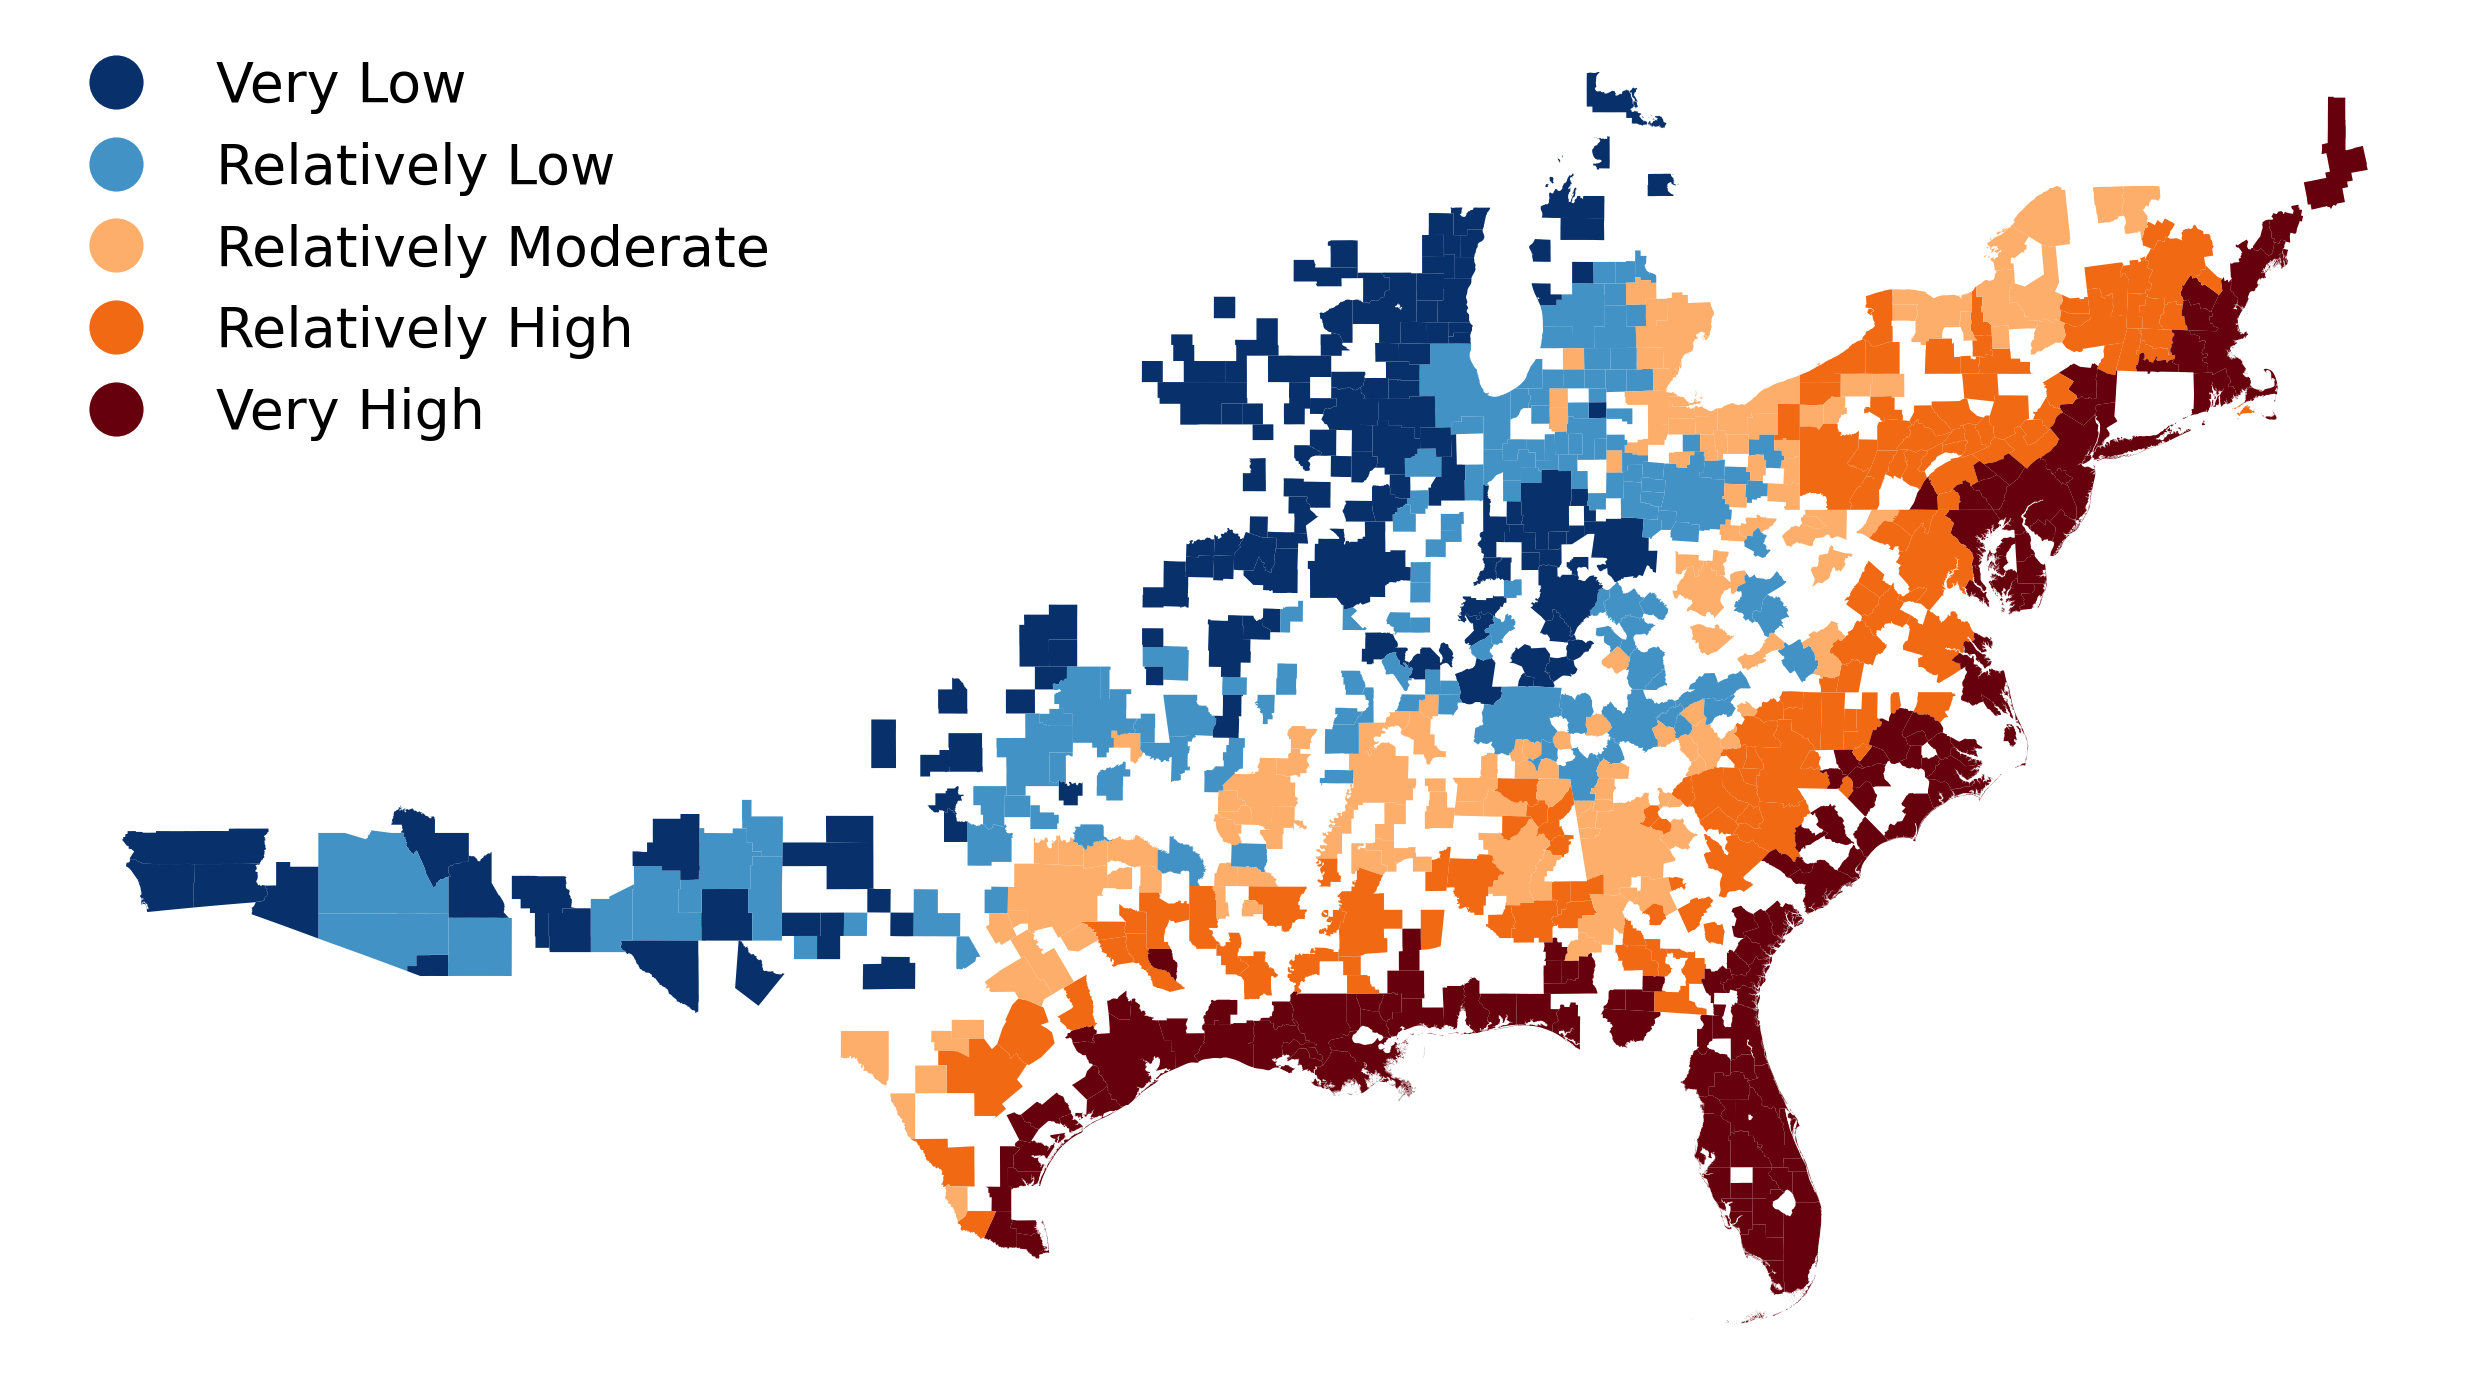

In [4]:
#5 bins based on quantiles to categorize the scores into 5 distinct sections
mainland_usa_gdf_msa_aggregated.loc[:,'HRCN_EALS_NORM'] = (mainland_usa_gdf_msa_aggregated['HRCN_EALS'] - mainland_usa_gdf_msa_aggregated['HRCN_EALS'].mean())/ mainland_usa_gdf_msa_aggregated['HRCN_EALS'].std()
mainland_usa_gdf_msa_aggregated.loc[:,'HRCN_RISK_CATEGORY_QUANTILE'] = pd.qcut(mainland_usa_gdf_msa_aggregated['HRCN_EALS_NORM'], q=5, labels=['Very Low', "Relatively Low", 'Relatively Moderate', 'Relatively High', 'Very High'])
colors = ['#08306b', '#4292c6', '#fdae6b', '#f16913', '#67000d']
custom_cmap = ListedColormap(colors)
#Plot the heatmap
fig, ax = plt.subplots(1, 1, figsize=(25, 15))
plt.grid(False)
mainland_usa_gdf_msa_aggregated.plot(
    column='HRCN_RISK_CATEGORY_QUANTILE', 
    cmap=custom_cmap, 
    linewidth=0.8, 
    ax=ax, 
    legend=True,
    legend_kwds={'loc': 'upper left', 'fontsize': 40, 'frameon': False})

# Create custom legend
legend_labels = ['Very Low', 'Relatively Low', 'Relatively Moderate', 'Relatively High', 'Very High']
legend_colors = colors  # Assuming 'colors' is defined as in your code snippet
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=40) for label, color in zip(legend_labels, legend_colors)]
ax.legend(handles=legend_handles, loc='upper left', fontsize=40, frameon=False)
# ax.set_title('Hurricane Risk Heatmap (USA) on MSA level', fontdict={'fontsize': '25', 'fontweight' : '3'})
#Remove all axis values
ax.set_xticks([])
ax.set_yticks([])
#Remove all axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Display the map
#Save plot heatmap
plt.tight_layout()  # Adjust layout to reduce whitespace
plt.savefig('../../Plots/hurricane_eals_heatmap_msa.png')
plt.show()

In [36]:
#extract MSA and geometry columns
geometry_key = mainland_usa_gdf_msa_aggregated[['MSA', 'geometry']]
#save geopandas dataframe to pickle
geometry_key.to_pickle('../../Data/geometry_key.pkl')

## Open connection SQL

In [3]:
db_path = "../../Database/thesis_database.db"
conn = sqlite3.connect(db_path)

In [4]:
mainland_usa_gdf_msa_aggregated = pd.read_pickle('../../Data/mainland_usa_gdf_msa_aggregated.pkl')

### Transform dataset to necessary

In [5]:
mainland_usa_gdf_msa_aggregated_df = pd.DataFrame(mainland_usa_gdf_msa_aggregated.copy())

In [8]:
#remove all columns beside MSA, HRCN_ALRA, HRCN_RISK_CATEGORY_QUANTILE, HRCN_AFREQ
mainland_usa_gdf_msa_aggregated_df = mainland_usa_gdf_msa_aggregated_df[['MSA', 'STATE','HRCN_HLRB', 'HRCN_AFREQ', 'HRCN_EALS']]
# mainland_usa_gdf_msa_aggregated_df = mainland_usa_gdf_msa_aggregated_df.drop(columns=['geometry'])
display(mainland_usa_gdf_msa_aggregated_df['STATE'].unique())


array(['Texas', 'Oklahoma', 'Michigan', 'Ohio', 'New Mexico', 'Georgia',
       'New York', 'North Carolina', 'Alabama', 'Louisiana', 'New Jersey',
       'Pennsylvania', 'Iowa', 'Massachusetts', 'Indiana', 'Wisconsin',
       'Florida', 'Arkansas', 'Kansas', 'Tennessee', 'Maine', 'Maryland',
       'Vermont', 'West Virginia', 'Virginia', 'Illinois', 'Kentucky',
       'Missouri', 'Mississippi', 'South Carolina', 'New Hampshire',
       'Delaware', 'California', 'Minnesota', 'Arizona',
       'District of Columbia'], dtype=object)

In [55]:
mainland_usa_gdf_msa_aggregated_df.to_sql('hrcn_risk_agg', conn, if_exists = "replace", index = False)

669

## Close connection SQL

In [15]:
conn.close()